In [114]:
#import relevant libraries

#general
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#NLP
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag


nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet')

#machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

#model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import silhouette_score

#preprocessing and pipleline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

#imbalanced data
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.neural_network import MLPClassifier

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andrewreusche/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#pull in the data

In [2]:
df= pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
raw_df= df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]
raw_df= raw_df.dropna()
raw_df = raw_df.drop_duplicates(keep='first')
raw_df = raw_df.rename(columns={'tweet_text': 'tweet', 
                                'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'})
raw_df['emotion'].value_counts(normalize= True)

emotion
No emotion toward brand or product    0.592613
Positive emotion                      0.327453
Negative emotion                      0.062734
I can't tell                          0.017200
Name: proportion, dtype: float64

In [5]:
rel_raw_df = raw_df[raw_df['emotion'] != "I can't tell"]
sentiment_map = {'No emotion toward brand or product': 0,
    'Positive emotion': 1,
    'Negative emotion': 0}
rel_raw_df['sentiment'] = rel_raw_df['emotion'].map(sentiment_map)
rel_raw_df['sentiment'].value_counts(normalize= True)

sentiment
0    0.666816
1    0.333184
Name: proportion, dtype: float64

rel_raw_df['tweet'][9088]

In [6]:
rel_raw_df["tweet"] = rel_raw_df["tweet"].str.lower()
rel_raw_df[:10]

,tweet,emotion,sentiment
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Negative emotion,0
1,@jessedee know about @fludapp ? awesome ipad/i...,Positive emotion,1
2,@swonderlin can not wait for #ipad 2 also. the...,Positive emotion,1
3,@sxsw i hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Positive emotion,1
5,@teachntech00 new ipad apps for #speechtherapy...,No emotion toward brand or product,0
7,"#sxsw is just starting, #ctia is around the co...",Positive emotion,1
8,beautifully smart and simple idea rt @madebyma...,Positive emotion,1
9,counting down the days to #sxsw plus strong ca...,Positive emotion,1
10,excited to meet the @samsungmobileus at #sxsw ...,Positive emotion,1


word_tokenize('hello i am mark')

In [7]:
#9092 is a nonsensical symbolized tweet, drop it
rel_raw_df= rel_raw_df.drop(9092)

In [8]:
#removing usernames
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '@' not in w]).strip())

#removing hashtags
rel_raw_df["tweet"]= rel_raw_df["tweet"].apply(lambda x : ' '.join(
    [w for w in x.split() if '#' not in w]))

#use ReGex to strip the tweets down to only what we want
def strip_token(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) #remove all links form tweets
    tweet = re.sub(r'&amp;', 'and', tweet) #convert all instances of '&amp' to 'and'
    tweet = re.sub(r"'", "", tweet) #removes " ' " converting "can't" to "cant"
    tweet = re.sub(r'_', ' ', tweet) #removes all '_' from tweets
    tweet = re.sub(r'[^\w\s]', ' ', tweet) #removes all non word characters from tweets
    tweet = re.sub(r'\d+\w*', '', tweet) #removes all numbers or character combinations that begin with numbers 
    tweet = re.sub(r'can not', "cant", tweet) #convert all instances of 'can not' to 'cant'
    tweet = re.sub(r'will not', "wont", tweet) #convert all instances of 'will not' to 'wont'
    tweet = re.sub(r'do not', "dont", tweet) #convert all instances of 'do not' to 'dont'
    tweet = re.sub(r'\b[^a-zA-Z]+', ' ', tweet) #should strip all non standard a-z characters left over 
    tokens = word_tokenize(tweet)
    return tokens
rel_raw_df['tweet_tokenized'] = rel_raw_df['tweet'].apply(strip_token)

#preview dataset
rel_raw_df

,tweet,emotion,sentiment,tweet_tokenized
0,i have a 3g iphone. after 3 hrs tweeting at it...,Negative emotion,0,"[i, have, a, iphone, after, hrs, tweeting, at,..."
1,know about ? awesome ipad/iphone app that you'...,Positive emotion,1,"[know, about, awesome, ipad, iphone, app, that..."
2,can not wait for 2 also. they should sale them...,Positive emotion,1,"[cant, wait, for, also, they, should, sale, th..."
3,i hope this year's festival isn't as crashy as...,Negative emotion,0,"[i, hope, this, years, festival, isnt, as, cra..."
4,"great stuff on fri marissa mayer (google), tim...",Positive emotion,1,"[great, stuff, on, fri, marissa, mayer, google..."
...,...,...,...,...
9087,"yup, but i don't have a third app yet. i'm on ...",No emotion toward brand or product,0,"[yup, but, i, dont, have, a, third, app, yet, ..."
9088,ipad everywhere. {link},Positive emotion,1,"[ipad, everywhere, link]"
9089,"wave, buzz... rt we interrupt your regularly s...",No emotion toward brand or product,0,"[wave, buzz, rt, we, interrupt, your, regularl..."
9090,"google's zeiger, a physician never reported po...",No emotion toward brand or product,0,"[googles, zeiger, a, physician, never, reporte..."


#this column is just a test

monkey=' _ the big_monkey / throws a yellow/bannana _/far'

#use ReGex to strip the tweets down to only what we want
def strip_token2(tweet):
    tweet = re.sub(r'http[s]?://\S+|www\.\S+', '', tweet) #remove all links form tweets
    tweet = re.sub(r'&amp;', 'and', tweet) #convert all instances of '&amp' to 'and'
    #tweet = re.sub(r'/', ' ', tweet) #removes all '/' from tweets
    tweet = re.sub(r'_', ' ', tweet) #removes all '_' from tweets
    tweet = re.sub(r'[^\w\s]', ' ', tweet) #removes all non word characters from tweets
    tweet = re.sub(r'\d+\w*', '', tweet) #removes all numbers or character combinations that begin with numbers 
    tweet = re.sub(r'can not', "cant", tweet) #convert all instances of 'can not' to 'cant'
    tweet = re.sub(r'will not', "wont", tweet) #convert all instances of 'will not' to 'wont'
    tweet = re.sub(r'do not', "dont", tweet) #convert all instances of 'do not' to 'dont'
    tokens = word_tokenize(tweet)
    return tokens

monkey2= strip_token2(monkey)

print(monkey2)

In [9]:
#create a new column to show how long the tweets are, shorter 
rel_raw_df['tweet_len']= rel_raw_df.tweet_tokenized.apply(lambda x : len(x))
#consider getting rid of all tweets that are less than 5 characters long
rel_raw_df[rel_raw_df['tweet_len']<5]

,tweet,emotion,sentiment,tweet_tokenized,tweet_len
14,great ipad app from http://tinyurl.com/4nqv92l,Positive emotion,1,"[great, ipad, app, from]",4
52,÷¼ what? ÷_ {link} ã_,No emotion toward brand or product,0,"[what, link]",2
77,i worship {link},No emotion toward brand or product,0,"[i, worship, link]",3
85,stay tune showcase {link},No emotion toward brand or product,0,"[stay, tune, showcase, link]",4
133,follow lead {link},No emotion toward brand or product,0,"[follow, lead, link]",3
...,...,...,...,...,...
8885,well put. totally agree!,No emotion toward brand or product,0,"[well, put, totally, agree]",4
8904,black or white ipad?,No emotion toward brand or product,0,"[black, or, white, ipad]",4
8923,"google arwords, arsense anyone?",No emotion toward brand or product,0,"[google, arwords, arsense, anyone]",4
9031,... or maybe not: {link},No emotion toward brand or product,0,"[or, maybe, not, link]",4


stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
#additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
#stopwords_list.append('additional_stopwords')

def remove_stopwords(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list]
    return list_stripped

rel_raw_df['tweet_tokenized_ns'] = rel_raw_df['tweet_tokenized'].apply(remove_stopwords)

rel_raw_df["tweet_tokenized_ns"]

rel_raw_df["tweet_tokenized_ns"][0]

In [10]:
#lemmetize the tokens
lemmatizer = WordNetLemmatizer()

def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

rel_raw_df['tweet_lem'] = rel_raw_df['tweet_tokenized'].apply(lem_tokens)

In [12]:
#random undersample here 

In [13]:
X= rel_raw_df['tweet_lem']
y= rel_raw_df['sentiment']

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

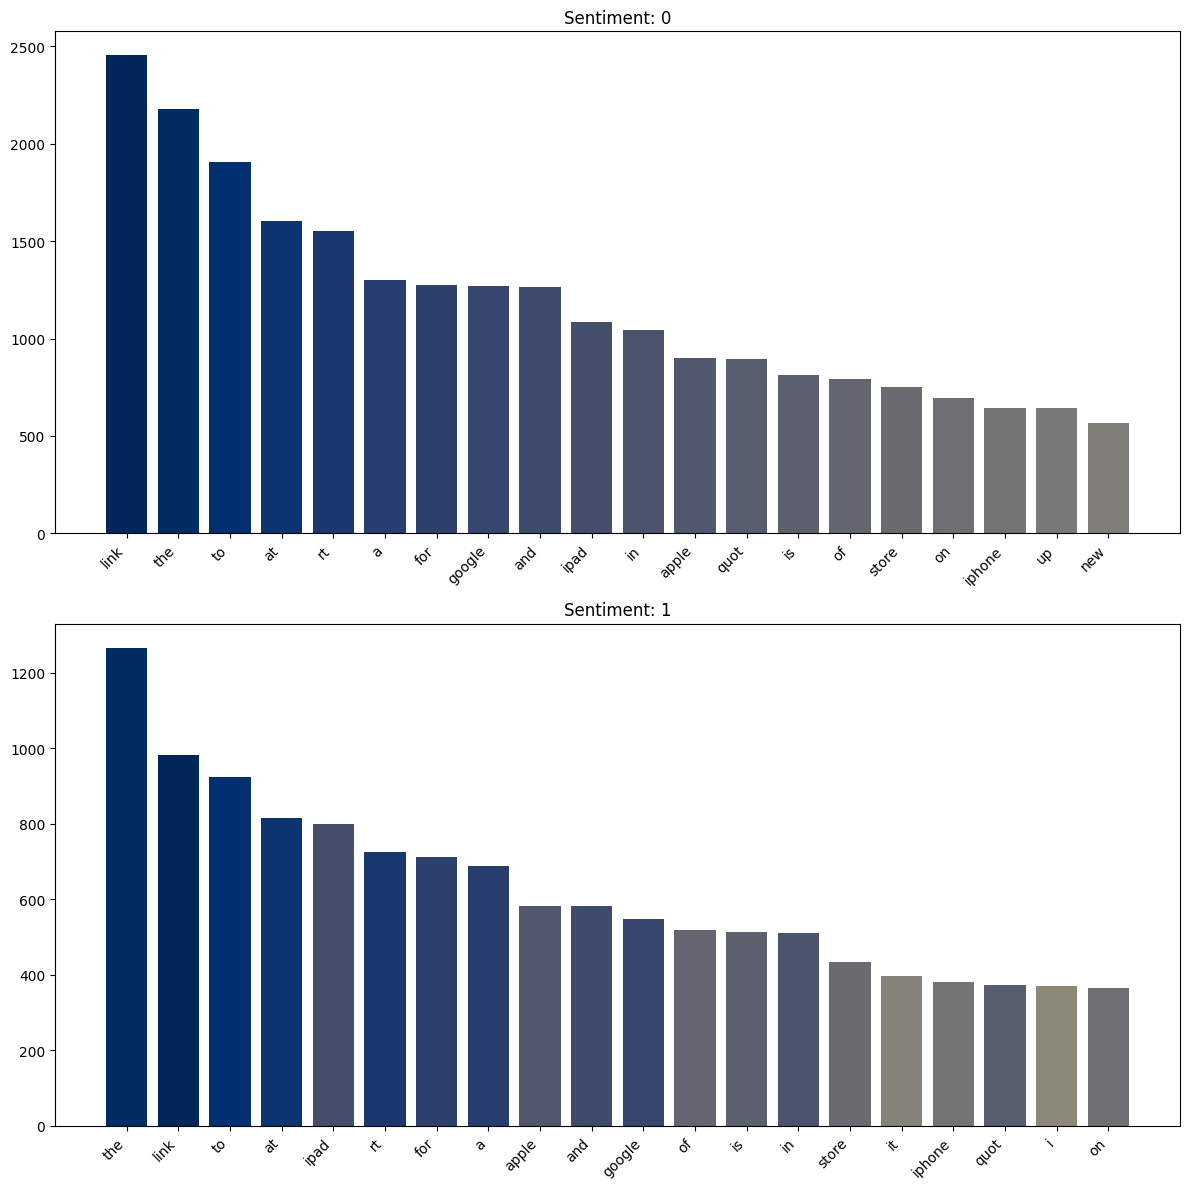

In [14]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train[y_train == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [15]:
type(X_train)

pandas.core.series.Series

In [16]:
rand_und = RandomUnderSampler(random_state=24)

X_train_str = X_train.apply(' '.join) 
X_train_resampled, y_train_resampled = rand_und.fit_resample(X_train_str.values.reshape(-1, 1), y_train)
X_train_resampled_tokens = pd.Series([sample[0].split(' ') for sample in X_train_resampled])
X_train_resampled_tokens

0       [dense, una, vuelta, por, para, ver, la, gran,...
1       [hey, folk, free, lunch, from, la, condesa, at...
2       [the, countdown, to, ha, begun, will, be, ther...
3       [rt, why, google, apple, ea, game, zynga, face...
4       [the, line, wa, too, long, the, other, day, bu...
                              ...                        
4783    [rt, ill, be, at, the, apple, store, tonight, ...
4784    [msft, panel, on, touch, interface, show, a, b...
4785    [questioner, at, just, said, quot, thanks, and...
4786    [rt, rt, yes, updated, iphone, app, ha, song, ...
4787    [the, pressure, ahem, excuse, to, buy, mount, ...
Length: 4788, dtype: object

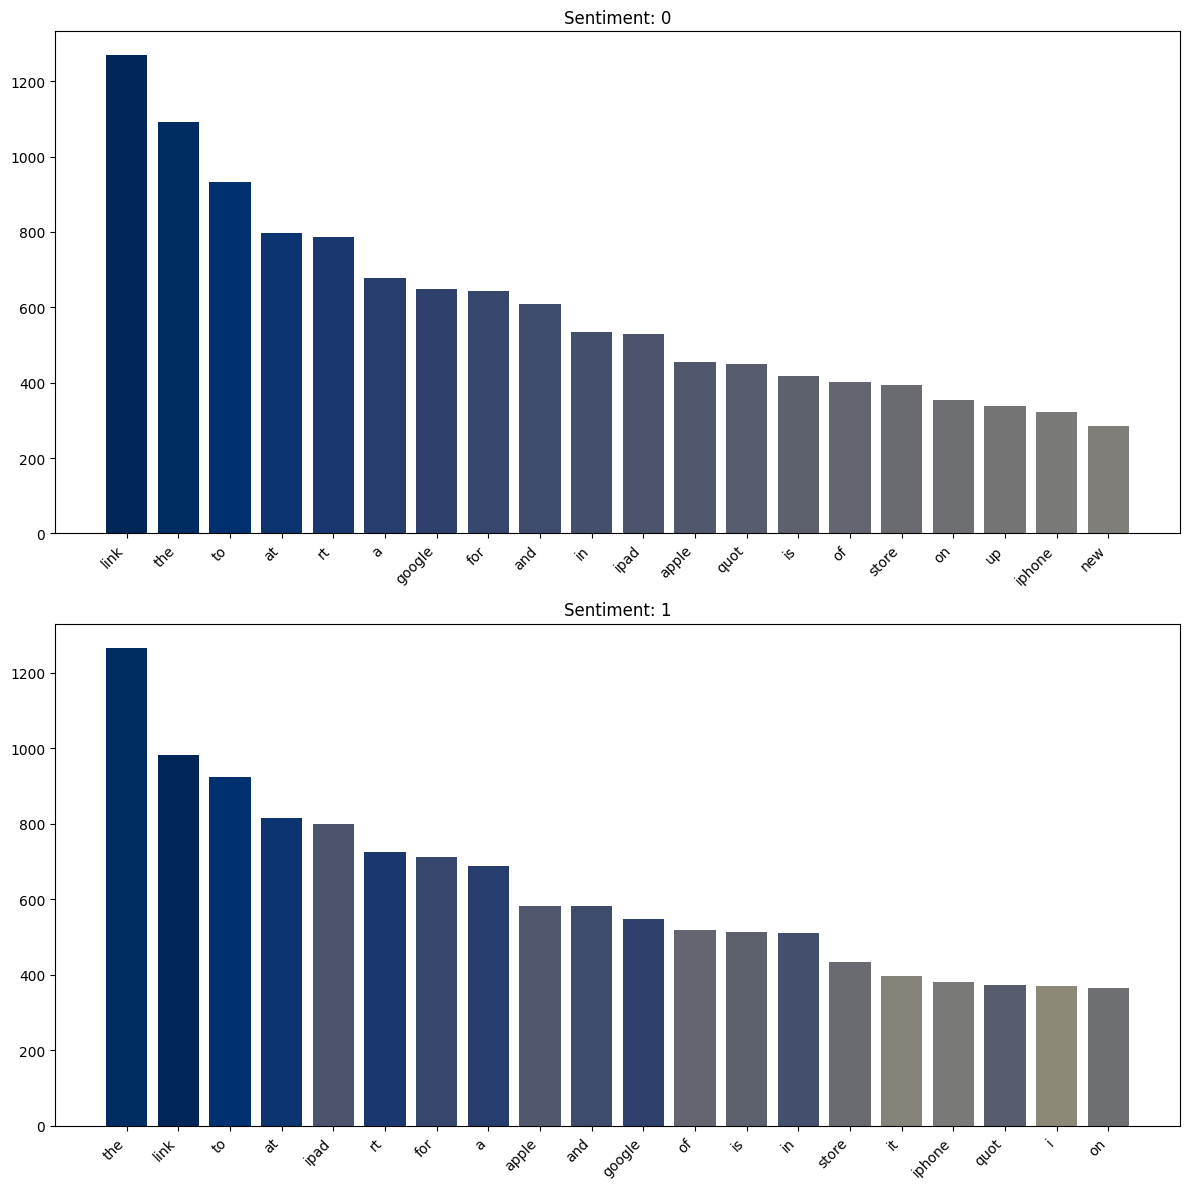

In [17]:
#check out the word distrobutions in X_train for each target class

from collections import Counter

color_palette = sns.color_palette('cividis', n_colors=38)

fig, axes = plt.subplots(nrows=2, figsize=(12, 12)) 

plotted_words_and_colors = {}

sentiment_classes = y_train.unique() 
for i, sentiment_class in enumerate(sentiment_classes):
    sentiment_data = X_train_resampled_tokens[y_train_resampled == sentiment_class]
    all_words_in_sentiment = [word for tokens in sentiment_data for word in tokens]
    top_10 = Counter(all_words_in_sentiment).most_common(20)
    
    colors = []
    
    for word, _ in top_10:
        if word not in plotted_words_and_colors:
            new_color = color_palette.pop(0)
            plotted_words_and_colors[word] = new_color
        colors.append(plotted_words_and_colors[word])
    
    ax = axes[i]
    words, counts = zip(*top_10)
    ax.bar(words, counts, color=colors)
    ax.set_title(f'Sentiment: {sentiment_class}') 
    ax.set_xticklabels(words, rotation=45, ha='right')

fig.tight_layout() 
plt.show()

In [18]:
# Join token lists into strings
X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

In [19]:
len(X_train_str)

7130

In [20]:
vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= 0.0, max_df= 1.0)
vector.fit(X_train_str)

TfidfVectorizer(max_features=2000, min_df=0.0)

In [21]:
#list(vector.get_feature_names_out())

In [22]:
#vector= TfidfVectorizer(max_features= 2000, ngram_range= (1,1), min_df= .001, max_df= 1.0)
#vector.fit(X_train_str.tolist())
#list(vector.get_feature_names_out())

In [23]:
#X_train_str[0]

In [13]:
stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
stopwords_list2= stopwords_list + additional_stopwords

In [26]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True, False],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7304
Validation Set Accuracy: 0.7565


In [27]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7304
Validation Set Accuracy: 0.7565


"""

"\n\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7304\nValidation Set Accuracy: 0.7565\n\n\n"

In [31]:
#v1.1
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [15]:
rel_raw_df[rel_raw_df['tweet_len']<5]

,tweet,emotion,sentiment,tweet_tokenized,tweet_len,tweet_lem
14,great ipad app from http://tinyurl.com/4nqv92l,Positive emotion,1,"[great, ipad, app, from]",4,"[great, ipad, app, from]"
52,÷¼ what? ÷_ {link} ã_,No emotion toward brand or product,0,"[what, link]",2,"[what, link]"
77,i worship {link},No emotion toward brand or product,0,"[i, worship, link]",3,"[i, worship, link]"
85,stay tune showcase {link},No emotion toward brand or product,0,"[stay, tune, showcase, link]",4,"[stay, tune, showcase, link]"
133,follow lead {link},No emotion toward brand or product,0,"[follow, lead, link]",3,"[follow, lead, link]"
...,...,...,...,...,...,...
8885,well put. totally agree!,No emotion toward brand or product,0,"[well, put, totally, agree]",4,"[well, put, totally, agree]"
8904,black or white ipad?,No emotion toward brand or product,0,"[black, or, white, ipad]",4,"[black, or, white, ipad]"
8923,"google arwords, arsense anyone?",No emotion toward brand or product,0,"[google, arwords, arsense, anyone]",4,"[google, arwords, arsense, anyone]"
9031,... or maybe not: {link},No emotion toward brand or product,0,"[or, maybe, not, link]",4,"[or, maybe, not, link]"


In [16]:
#run this on the dataset where all X_train tweets are >=5 in length 
rel_raw_df_long= rel_raw_df[rel_raw_df['tweet_len']>=5]

rel_raw_df_long['tweet_lem'] = rel_raw_df_long['tweet_tokenized'].apply(lem_tokens)

X_long= rel_raw_df_long['tweet_lem']
y_long= rel_raw_df_long['sentiment']



#Train split (remain is the remaining data)
X_train_long, X_remain_long, y_train_long, y_remain_long= train_test_split(X_long, y_long, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val_long, X_test_long, y_val_long, y_test_long= train_test_split(X_remain_long, y_remain_long,
                                               test_size= 0.5, 
                                               random_state= 24)


X_train_str_long = X_train_long.apply(' '.join)
X_val_str_long = X_val_long.apply(' '.join)
X_test_str_long = X_test_long.apply(' '.join)

pipeline_long = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True, False],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search_long = GridSearchCV(
    pipeline_long,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search_long.fit(X_train_str_long, y_train_long)

# Get the best train cross-validation score
best_train_cv_score = grid_search_long.best_score_

# Get the best model found by grid search
best_model = grid_search_long.best_estimator_

# Predict on the validation set
y_val_pred_long = best_model.predict(X_val_str_long)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val_long, y_val_pred_long)

# Get the best hyperparameters
best_params = grid_search_long.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2500, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7303
Validation Set Accuracy: 0.7305


In [ ]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2500, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7303
Validation Set Accuracy: 0.7305

"""

In [ ]:
#run this on the dataset where all X_train tweets are >=5 in length 
rel_raw_df_long= rel_raw_df[rel_raw_df['tweet_len']>=5]

rel_raw_df_long['tweet_lem'] = rel_raw_df_long['tweet_tokenized'].apply(lem_tokens)

X_long= rel_raw_df_long['tweet_lem']
y_long= rel_raw_df_long['sentiment']



#Train split (remain is the remaining data)
X_train_long, X_remain_long, y_train_long, y_remain_long= train_test_split(X_long, y_long, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val_long, X_test_long, y_val_long, y_test_long= train_test_split(X_remain_long, y_remain_long,
                                               test_size= 0.5, 
                                               random_state= 24)


X_train_str_long = X_train_long.apply(' '.join)
X_val_str_long = X_val_long.apply(' '.join)
X_test_str_long = X_test_long.apply(' '.join)

pipeline_long = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True, False],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search_long = GridSearchCV(
    pipeline_long,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search_long.fit(X_train_str_long, y_train_long)

# Get the best train cross-validation score
best_train_cv_score = grid_search_long.best_score_

# Get the best model found by grid search
best_model = grid_search_long.best_estimator_

# Predict on the validation set
y_val_pred_long = best_model.predict(X_val_str_long)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val_long, y_val_pred_long)

# Get the best hyperparameters
best_params = grid_search_long.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

In [ ]:
step1: train test split
step: calc length on x train 
step: filter x train


In [22]:
X= rel_raw_df[['tweet_lem', 'tweet_len']]
X.head()

,tweet_lem,tweet_len
0,"[i, have, a, iphone, after, hr, tweeting, at, ...",18
1,"[know, about, awesome, ipad, iphone, app, that...",19
2,"[cant, wait, for, also, they, should, sale, th...",10
3,"[i, hope, this, year, festival, isnt, a, crash...",13
4,"[great, stuff, on, fri, marissa, mayer, google...",16


In [25]:
#run this on the dataset where all X_train tweets are >=5 in length but best and val are unstripped
rel_raw_df_long= rel_raw_df[rel_raw_df['tweet_len']>=5]

rel_raw_df_long['tweet_lem'] = rel_raw_df_long['tweet_tokenized'].apply(lem_tokens)

X_long= rel_raw_df_long['tweet_lem']
y_long= rel_raw_df_long['sentiment']

X= rel_raw_df[['tweet_lem', 'tweet_len']]
y= rel_raw_df[['sentiment', 'tweet_len']]

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

X_train= X_train[X_train['tweet_len']>=5]
y_train= y_train[y_train['tweet_len']>=5]

X_train= X_train['tweet_lem']
y_train= y_train['sentiment']
X_val= X_val['tweet_lem']
X_test= X_test['tweet_lem']
y_val= y_val['sentiment']
y_test= y_test['sentiment']

X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid2 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search= GridSearchCV(
    pipeline2,
    param_grid2,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search.best_score_

# Get the best model found by grid search
best_model = grid_search.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"]}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7508

"""

In [ ]:
#run this on the dataset where all X_train tweets are >=5 in length but best and val are unstripped v2 diff params
rel_raw_df_long= rel_raw_df[rel_raw_df['tweet_len']>=5]

rel_raw_df_long['tweet_lem'] = rel_raw_df_long['tweet_tokenized'].apply(lem_tokens)

X_long= rel_raw_df_long['tweet_lem']
y_long= rel_raw_df_long['sentiment']

X= rel_raw_df[['tweet_lem', 'tweet_len']]
y= rel_raw_df[['sentiment', 'tweet_len']]

#Train split (remain is the remaining data)
X_train, X_remain, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val, X_test, y_val, y_test= train_test_split(X_remain, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

X_train= X_train[X_train['tweet_len']>=5]
y_train= y_train[y_train['tweet_len']>=5]

X_train= X_train['tweet_lem']
y_train= y_train['sentiment']
X_val= X_val['tweet_lem']
X_test= X_test['tweet_lem']
y_val= y_val['sentiment']
y_test= y_test['sentiment']

X_train_str = X_train.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)

pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))])
#make a parameter grid
param_grid2 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__min_df': [0.001, 0.0001],
    'tfidf__max_df': [0.65, 0.85, 1.0],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'clf__C': [0.01, 1 10],                  # 4
    'clf__fit_intercept': [True, False],            # 2
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 1.5}],  # 3
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # 3
    'clf__tol': [1e-4, 1e-2]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search= GridSearchCV(
    pipeline2,
    param_grid2,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search.best_score_

# Get the best model found by grid search
best_model = grid_search.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

In [32]:
#run this on the random undersampled dataset
#this seems to hurt things

# Join token lists into strings
X_train_str_ru = X_train_resampled_tokens.apply(' '.join)
X_val_str = X_val.apply(' '.join)
X_test_str = X_test.apply(' '.join)


pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tfidf__max_df': [1.0]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str_ru, y_train_resampled)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6748
Validation Set Accuracy: 0.6891


In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6748
Validation Set Accuracy: 0.6891

"""

In [35]:
print(stopwords_list2)

None


In [36]:
#run this on the adjusted stopword dataset

stopwords_list= stopwords.words('english')
stopwords_list = [word for word in stopwords_list if word not in ['not', 'can']]
#possibly append words to the list of stop words
additional_stopwords= ['google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw']
stopwords_list2= stopwords_list + additional_stopwords

def remove_stopwords2(token_list):
    list_stripped= [x for x in token_list if x not in stopwords_list2]
    return list_stripped

rel_raw_df['tweet_tokenized_ns2']= rel_raw_df['tweet_tokenized'].apply(remove_stopwords2)

rel_raw_df['tweet_lem2'] = rel_raw_df['tweet_tokenized_ns2'].apply(lem_tokens)

X= rel_raw_df['tweet_lem2']
y= rel_raw_df['sentiment']

#Train split (remain is the remaining data)
X_train2, X_remain2, y_train, y_remain= train_test_split(X, y, 
                                                   test_size= 0.2,  
                                                   random_state= 24)

#Val test split 
X_val2, X_test2, y_val, y_test= train_test_split(X_remain2, y_remain,
                                               test_size= 0.5, 
                                               random_state= 24)

# Join token lists into strings
X_train_str2= X_train2.apply(' '.join)
X_val_str2= X_val2.apply(' '.join)
X_test_str2= X_test2.apply(' '.join)


pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500],
    'tfidf__ngram_range': [(1, 1), (1,2), (2,2), (1,3), (3,3), (1,5), (5,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001],
    'tfidf__max_df': [1.0]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str2, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str2)

# Evaluate performance (accuracy) on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7234
Validation Set Accuracy: 0.7430


In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 1.0, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3)}
Best Train Cross-Validation Score: 0.7234
Validation Set Accuracy: 0.7430

"""

In [28]:
X_list_1= X_train_str[:100]

In [29]:
pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3000],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [0.2],
    'tfidf__max_df': [0.8]}

#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

grid_search1.fit(X_train_str, y_train)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.2, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6642
Validation Set Accuracy: 0.6846


In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 0.2, 'tfidf__ngram_range': (1, 2)}
Best Train Cross-Validation Score: 0.6642
Validation Set Accuracy: 0.6846

"""

In [30]:
X_list_2= X_train_str[:100]

In [31]:
X_list_2[:100]

2915              opening popup shop downtown austin link
6476    rt remember chime tweet experience central tim...
6347     rt new app store inclds uberguide sponsored link
8164                  sxsw first lecture phone turn stove
8877    crowley growing foursquare competitor facebook...
                              ...                        
8805                          loving new iphone w channel
959                        omgjk kiss ipad slap xoom link
8864    crowd austin swarm ipad launch link via sadly ...
3012    ahh wonderful news rt ipad available online or...
332     long line apple pop store ipad great marketing...
Name: tweet_lem, Length: 100, dtype: object

In [32]:
X_list_1[:100]

2915              opening popup shop downtown austin link
6476    rt remember chime tweet experience central tim...
6347     rt new app store inclds uberguide sponsored link
8164                  sxsw first lecture phone turn stove
8877    crowley growing foursquare competitor facebook...
                              ...                        
8805                          loving new iphone w channel
959                        omgjk kiss ipad slap xoom link
8864    crowd austin swarm ipad launch link via sadly ...
3012    ahh wonderful news rt ipad available online or...
332     long line apple pop store ipad great marketing...
Name: tweet_lem, Length: 100, dtype: object

# logistic regression

In [ ]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

In [32]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7304
Validation Set Accuracy: 0.7565


"""

"\n\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7304\nValidation Set Accuracy: 0.7565\n\n\n"

In [55]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3)],
    'tfidf__min_df': [0.0, 50, 100],
    'tfidf__max_df': [0.95, 1],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list2, stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [53]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.75, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7278
Validation Set Accuracy: 0.7475
"""

'\nBest Hyperparameters: {\'tfidf__max_df\': 0.75, \'tfidf__max_features\': 4000, \'tfidf__min_df\': 0.0, \'tfidf__ngram_range\': (1, 3), \'tfidf__stop_words\': [\'a\', \'about\', \'above\', \'after\', \'again\', \'against\', \'ain\', \'all\', \'am\', \'an\', \'and\', \'any\', \'are\', \'aren\', "aren\'t", \'as\', \'at\', \'be\', \'because\', \'been\', \'before\', \'being\', \'below\', \'between\', \'both\', \'but\', \'by\', \'couldn\', "couldn\'t", \'d\', \'did\', \'didn\', "didn\'t", \'do\', \'does\', \'doesn\', "doesn\'t", \'doing\', \'don\', "don\'t", \'down\', \'during\', \'each\', \'few\', \'for\', \'from\', \'further\', \'had\', \'hadn\', "hadn\'t", \'has\', \'hasn\', "hasn\'t", \'have\', \'haven\', "haven\'t", \'having\', \'he\', "he\'d", "he\'ll", \'her\', \'here\', \'hers\', \'herself\', "he\'s", \'him\', \'himself\', \'his\', \'how\', \'i\', "i\'d", \'if\', "i\'ll", "i\'m", \'in\', \'into\', \'is\', \'isn\', "isn\'t", \'it\', "it\'d", "it\'ll", "it\'s", \'its\', \'itself\', 

In [57]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1,2), (2,2), (1,3)],
    'tfidf__min_df': [0.0, 2],
    'tfidf__max_df': [0.95, 1],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7531


In [58]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7531
"""

"\nBest Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7275\nValidation Set Accuracy: 0.7531\n"

In [59]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24, 
                               C=1,
                               class_weight=None,
                               fit_intercept=True,
                               solver='saga',
                               tol=0.0001))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1,2), (2,2), (1,3)],
    'tfidf__min_df': [0.0, 2],
    'tfidf__max_df': [0.95, 1],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [60]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7278
Validation Set Accuracy: 0.7475
"""

'\n\nBest Hyperparameters: {\'tfidf__max_df\': 0.95, \'tfidf__max_features\': 4000, \'tfidf__min_df\': 0.0, \'tfidf__ngram_range\': (1, 3), \'tfidf__stop_words\': [\'a\', \'about\', \'above\', \'after\', \'again\', \'against\', \'ain\', \'all\', \'am\', \'an\', \'and\', \'any\', \'are\', \'aren\', "aren\'t", \'as\', \'at\', \'be\', \'because\', \'been\', \'before\', \'being\', \'below\', \'between\', \'both\', \'but\', \'by\', \'couldn\', "couldn\'t", \'d\', \'did\', \'didn\', "didn\'t", \'do\', \'does\', \'doesn\', "doesn\'t", \'doing\', \'don\', "don\'t", \'down\', \'during\', \'each\', \'few\', \'for\', \'from\', \'further\', \'had\', \'hadn\', "hadn\'t", \'has\', \'hasn\', "hasn\'t", \'have\', \'haven\', "haven\'t", \'having\', \'he\', "he\'d", "he\'ll", \'her\', \'here\', \'hers\', \'herself\', "he\'s", \'him\', \'himself\', \'his\', \'how\', \'i\', "i\'d", \'if\', "i\'ll", "i\'m", \'in\', \'into\', \'is\', \'isn\', "isn\'t", \'it\', "it\'d", "it\'ll", "it\'s", \'its\', \'itself\'

In [63]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__sublinear_tf': [True],
    'clf__C': [0.01, 0.1, 1, 10],                  # 4
    'clf__fit_intercept': [True, False],            # 2
    'clf__class_weight': [None, 'balanced', {0: 1, 1: 1.5}],  # 3
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],  # 3
    'clf__tol': [1e-4, 1e-3, 1e-2]}                 # 3}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'liblinear', 'clf__tol': 0.0001, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7531


In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'google', 'iphone', 'ipad', 'link', 'apple', 'rt', 'store', 'quot', 'austin', 'via', 'sxsw'], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7230
Validation Set Accuracy: 0.7396

"""

In [ ]:
"""
Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'liblinear', 'clf__tol': 0.0001, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7275
Validation Set Accuracy: 0.7531
"""

In [64]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3000, 3500],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__sublinear_tf': [True],
    'clf__C': [0, 1, 2],                  # 4
    'clf__fit_intercept': [True, False],            # 2
    'clf__class_weight': [None],  # 3
    'clf__solver': ['liblinear'],  # 3
    'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3]}                 # 3}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'liblinear', 'clf__tol': 1e-06, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7277
Validation Set Accuracy: 0.7531


In [65]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(random_state=24))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english'],
    'tfidf__sublinear_tf': [True],
    'clf__C': [1],                  # 4
    'clf__fit_intercept': [True, False],            # 2
    'clf__class_weight': [None],  # 3
    'clf__solver': ['liblinear'],  # 3
    'clf__tol': [1e-6]}                 # 3}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__C': 1, 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__solver': 'liblinear', 'clf__tol': 1e-06, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': 'english', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7277
Validation Set Accuracy: 0.7531


### best log reg score train 0.7277 val 0.7531

# xg boost

In [44]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [3500, 4000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__min_df': [0.0, 0.01],
    'tfidf__max_df': [0.85, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, None],
    'tfidf__sublinear_tf': [True]}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.1, 0.3],  # Default is 0.3
    'clf__scale_pos_weight': [2]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")


Fitting 5 folds for each of 256 candidates, totalling 1280 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 2, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.6995
Validation Set Accuracy: 0.7273

Comparison:
Logistic Regression (Base) Validation Accuracy: 0.7576
XGBoost Validation Accuracy: 0.7273


In [45]:
"""
Fitting 5 folds for each of 256 candidates, totalling 1280 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 2, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.6995
Validation Set Accuracy: 0.7273

"""

"\nFitting 5 folds for each of 256 candidates, totalling 1280 fits\n\nXGBoost Results:\nBest Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 2, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.6995\nValidation Set Accuracy: 0.7273\n\nComparison:\nLogistic Regression (Base) Validation Accuracy: 0.7576\nXGBoost Validation Accuracy: 0.7273\n"

In [46]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__min_df': [0.0, 0.0001],
    'tfidf__max_df': [0.85],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english', None],
    'tfidf__sublinear_tf': [True]}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [200, 300],
    'clf__max_depth': [4, 5, 6],
    'clf__learning_rate': [0.3, 0.4],  # Default is 0.3
    'clf__scale_pos_weight': [1, 2, 3]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")


Fitting 5 folds for each of 288 candidates, totalling 1440 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7239
Validation Set Accuracy: 0.7497


In [ ]:
#this is an improvement from the previous xgb

"""
XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7239
Validation Set Accuracy: 0.7497
"""

In [47]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1,2), (1,3)],
    'tfidf__min_df': [0.0, 0.0001],
    'tfidf__max_df': [0.85],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english', None],
    'tfidf__sublinear_tf': [True]}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [175, 200, 225],
    'clf__max_depth': [5],
    'clf__learning_rate': [0.2, 0.3],  # Default is 0.3
    'clf__scale_pos_weight': [0, 1]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7239
Validation Set Accuracy: 0.7497


In [48]:
"""
Fitting 5 folds for each of 96 candidates, totalling 480 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7239
Validation Set Accuracy: 0.7497
"""

"\nFitting 5 folds for each of 96 candidates, totalling 480 fits\n\nXGBoost Results:\nBest Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7239\nValidation Set Accuracy: 0.7497\n"

In [49]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [3000, 3500, 4000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 2],
    'tfidf__max_df': [0.75, 0.85, 0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list2, 'english', None],
    'tfidf__sublinear_tf': [True]}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [200],
    'clf__max_depth': [5],
    'clf__learning_rate': [0.3],  # Default is 0.3
    'clf__scale_pos_weight': [1]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.75, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7246
Validation Set Accuracy: 0.7374


In [50]:
# Base param grid for TF-IDF
base_param_grid = {
    'tfidf__max_features': [3000, 3500, 4000],
    'tfidf__ngram_range': [(1,1), (1,2), (1,3)],
    'tfidf__min_df': [ 2, 10, 100],
    'tfidf__max_df': [0.65, 0.75, 0.85,],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list2, stopwords_list2, 'english', None],
    'tfidf__sublinear_tf': [True]}

# XGBoost Pipeline
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', XGBClassifier(random_state=24, use_label_encoder=False, eval_metric='logloss'))
])

# Parameter grid for XGBoost
param_grid_xgb = {
    **base_param_grid,
    'clf__n_estimators': [200],
    'clf__max_depth': [5],
    'clf__learning_rate': [0.3],  # Default is 0.3
    'clf__scale_pos_weight': [1]}

# Run grid search
grid_search_xgb = GridSearchCV(
    pipeline_xgb,
    param_grid_xgb,
    cv=5,
    scoring='accuracy',
    n_jobs=1,
    verbose=1
)

# Fit on training data
grid_search_xgb.fit(X_train_str, y_train)

# Results
best_train_cv_score_xgb = grid_search_xgb.best_score_
best_model_xgb = grid_search_xgb.best_estimator_
y_val_pred_xgb = best_model_xgb.predict(X_val_str)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)
best_params_xgb = grid_search_xgb.best_params_

print("\nXGBoost Results:")
print(f"Best Hyperparameters: {best_params_xgb}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score_xgb:.4f}")
print(f"Validation Set Accuracy: {val_accuracy_xgb:.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.65, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7246
Validation Set Accuracy: 0.7374


In [51]:
"""
XGBoost Results:
Best Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.65, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7246
Validation Set Accuracy: 0.7374

"""

"\nXGBoost Results:\nBest Hyperparameters: {'clf__learning_rate': 0.3, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__scale_pos_weight': 1, 'tfidf__max_df': 0.65, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7246\nValidation Set Accuracy: 0.7374\n\n"

### best xgb score train: 0.7246  val:  0.7374

# Multinomial Naive Bayes

In [66]:
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7130
Validation Set Accuracy: 0.7520


In [67]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7130
Validation Set Accuracy: 0.7520

"""

"\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7130\nValidation Set Accuracy: 0.7520\n\n"

In [69]:
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000,],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'clf__fit_prior': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7154
Validation Set Accuracy: 0.7520


In [70]:
"""
Best Hyperparameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7154
Validation Set Accuracy: 0.7520
"""

"\nBest Hyperparameters: {'clf__alpha': 0.1, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7154\nValidation Set Accuracy: 0.7520\n"

In [71]:
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000,],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__alpha': [0.01, 0.001, 0.0001, 0.00001, 0.000001],
    'clf__fit_prior': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7148
Validation Set Accuracy: 0.7542


In [72]:
"""
Best Hyperparameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7148
Validation Set Accuracy: 0.7542
"""

"\nBest Hyperparameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7148\nValidation Set Accuracy: 0.7542\n"

In [74]:
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000,],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__alpha': [0.01],
    'clf__fit_prior': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__alpha': 0.01, 'clf__fit_prior': True, 'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7148
Validation Set Accuracy: 0.7542


### best multi NB score Train 0.7148, val 0.7542
### best log reg score train 0.7277 val 0.7531
### best xgb score train: 0.7246 val: 0.7374

# linear SVC

In [75]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 2, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7285
Validation Set Accuracy: 0.7710
"""

In [84]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', '

In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7285
Validation Set Accuracy: 0.7710
"""

In [85]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True],
    'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__loss': ['hinge', 'squared_hinge'],
    'clf__tol': [1e-4, 1e-3, 1e-2, 1e-1]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__C': 1, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'clf__tol': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn

In [86]:
"""
Best Hyperparameters: {'clf__C': 1, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'clf__tol': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "shouldn't", "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we', "we'd", "we'll", "we're", 'were', 'weren', "weren't", "we've", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't", 'wouldn', "wouldn't", 'y', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've"], 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7288
Validation Set Accuracy: 0.7710
"""

'\nBest Hyperparameters: {\'clf__C\': 1, \'clf__loss\': \'squared_hinge\', \'clf__penalty\': \'l2\', \'clf__tol\': 0.1, \'tfidf__max_df\': 0.95, \'tfidf__max_features\': 3500, \'tfidf__min_df\': 0.0, \'tfidf__ngram_range\': (1, 1), \'tfidf__stop_words\': [\'a\', \'about\', \'above\', \'after\', \'again\', \'against\', \'ain\', \'all\', \'am\', \'an\', \'and\', \'any\', \'are\', \'aren\', "aren\'t", \'as\', \'at\', \'be\', \'because\', \'been\', \'before\', \'being\', \'below\', \'between\', \'both\', \'but\', \'by\', \'couldn\', "couldn\'t", \'d\', \'did\', \'didn\', "didn\'t", \'do\', \'does\', \'doesn\', "doesn\'t", \'doing\', \'don\', "don\'t", \'down\', \'during\', \'each\', \'few\', \'for\', \'from\', \'further\', \'had\', \'hadn\', "hadn\'t", \'has\', \'hasn\', "hasn\'t", \'have\', \'haven\', "haven\'t", \'having\', \'he\', "he\'d", "he\'ll", \'her\', \'here\', \'hers\', \'herself\', "he\'s", \'him\', \'himself\', \'his\', \'how\', \'i\', "i\'d", \'if\', "i\'ll", "i\'m", \'in\', 

In [88]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True],
    'clf__C': [1,],
    'clf__penalty': ['l2'],
    'clf__loss': ['squared_hinge'],
    'clf__tol': [1e-1]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__C': 1, 'clf__loss': 'squared_hinge', 'clf__penalty': 'l2', 'clf__tol': 0.1, 'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 0.0, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn

### best multi NB score Train 0.7148, val 0.7542
### best log reg score train 0.7277 val 0.7531
### best xgb score train: 0.7246 val: 0.7374
### best linear svc score train: 0.7288 val: 0.7710 current leader

# random forrest

In [90]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 2, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7285
Validation Set Accuracy: 0.7531


In [91]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7285
Validation Set Accuracy: 0.7531
"""

"\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7285\nValidation Set Accuracy: 0.7531\n"

In [94]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [ 2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [10, 20, None],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 'log2', None],
    'clf__bootstrap': [True, False]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7309
Validation Set Accuracy: 0.7632


In [95]:
"""
Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7309
Validation Set Accuracy: 0.7632

"""

"\nBest Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7309\nValidation Set Accuracy: 0.7632\n\n"

In [96]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [ 2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [150, 200, 250],
    'clf__max_depth': [None],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [1],
    'clf__max_features': ['sqrt'],
    'clf__bootstrap': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7314
Validation Set Accuracy: 0.7643


In [97]:
"""
Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7314
Validation Set Accuracy: 0.7643
"""

"\nBest Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7314\nValidation Set Accuracy: 0.7643\n"

In [99]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000],
    'tfidf__ngram_range': [(1,2)],
    'tfidf__min_df': [ 2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [150],
    'clf__max_depth': [None],
    'clf__min_samples_split': [10],
    'clf__min_samples_leaf': [1],
    'clf__max_features': ['sqrt'],
    'clf__bootstrap': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7314
Validation Set Accuracy: 0.7643


In [100]:
"""
Best Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7314
Validation Set Accuracy: 0.7643
"""

"\nBest Hyperparameters: {'clf__bootstrap': True, 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 150, 'tfidf__max_df': 0.95, 'tfidf__max_features': 2000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7314\nValidation Set Accuracy: 0.7643\n"

### best multi NB score Train 0.7148, val 0.7542
### best log reg score train 0.7277 val 0.7531
### best xgb score train: 0.7246 val: 0.7374
### best linear svc score train: 0.7288 val: 0.7710 current leader
### best random forest score train: 0.7314  val: 0.7643

# Gradient boosting

In [102]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 2, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

KeyboardInterrupt: 

In [103]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 3000, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3)],
    'tfidf__min_df': [0.0, 2, 0.01],
    'tfidf__max_df': [0.85, 0.95, 1.0],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7104
Validation Set Accuracy: 0.7497


In [104]:
"""

Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7104
Validation Set Accuracy: 0.7497
"""

"\n\nBest Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7104\nValidation Set Accuracy: 0.7497\n"

In [105]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500, 4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': ['english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7104
Validation Set Accuracy: 0.7464


In [106]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7104
Validation Set Accuracy: 0.7464
"""

"\nBest Hyperparameters: {'tfidf__max_df': 0.95, 'tfidf__max_features': 3500, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7104\nValidation Set Accuracy: 0.7464\n"

In [108]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [100, 200, 300],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [3, 4, 5],
    'clf__subsample': [0.8, 0.9, 1.0],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 5],
    'clf__loss': ['deviance', 'exponential']}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7280
Validation Set Accuracy: 0.7587


In [109]:
"""
Best Hyperparameters: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7280
Validation Set Accuracy: 0.7587
"""

"\nBest Hyperparameters: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 5, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7280\nValidation Set Accuracy: 0.7587\n"

In [110]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [300, 400],
    'clf__learning_rate': [0.1, 0.2],
    'clf__max_depth': [5, 6, 7],
    'clf__subsample': [0.7, 0.8],
    'clf__min_samples_split': [2, 3, 4],
    'clf__min_samples_leaf': [4, 5, 6],
    'clf__loss': ['exponential']}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 7, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7322
Validation Set Accuracy: 0.7621


In [ ]:
"""
Best Hyperparameters: {'clf__learning_rate': 0.1, 'clf__loss': 'exponential', 'clf__max_depth': 7, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.8, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7322
Validation Set Accuracy: 0.7621
"""

In [111]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [250, 300, 350],
    'clf__learning_rate': [0.05, 0.1, 0.15],
    'clf__max_depth': [7, 8, 9],
    'clf__subsample': [0.75, 0.8, 0.85, 0.9],
    'clf__min_samples_split': [1, 2, 3],
    'clf__min_samples_leaf': [3, 4, 5],
    'clf__loss': ['exponential']}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__learning_rate': 0.05, 'clf__loss': 'exponential', 'clf__max_depth': 9, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.85, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7334
Validation Set Accuracy: 0.7609


In [ ]:
"""
Best Hyperparameters: {'clf__learning_rate': 0.05, 'clf__loss': 'exponential', 'clf__max_depth': 9, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.85, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7334
Validation Set Accuracy: 0.7609
"""

In [112]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', GradientBoostingClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [4000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [2],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__n_estimators': [300],
    'clf__learning_rate': [0.05],
    'clf__max_depth': [9],
    'clf__subsample': [0.85],
    'clf__min_samples_split': [2],
    'clf__min_samples_leaf': [4],
    'clf__loss': ['exponential']}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__learning_rate': 0.05, 'clf__loss': 'exponential', 'clf__max_depth': 9, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 300, 'clf__subsample': 0.85, 'tfidf__max_df': 0.95, 'tfidf__max_features': 4000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7334
Validation Set Accuracy: 0.7609


### best multi NB score Train 0.7148, val 0.7542
### best log reg score train 0.7277 val 0.7531
### best xgb score train: 0.7246 val: 0.7374
### best linear svc score train: 0.7288 val: 0.7710 current leader
### best random forest score train: 0.7314 val: 0.7643
### best gradient boosting score train: 0.7322 val: 0.7621 vs train 0.7334 val 0.7609# #


# MLP Calssifier

In [122]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [2000, 2500, 3000, 3500, 4000],
    'tfidf__ngram_range': [(1, 1), (1,2), (1,3), (1,5)],
    'tfidf__min_df': [0.0, 2, 0.1, 0.01, 0.001, 0.0001],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list, 'english', None],
    'tfidf__sublinear_tf': [True]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

KeyboardInterrupt: 

In [ ]:
"""
Best Hyperparameters: {'tfidf__max_df': 0.85, 'tfidf__max_features': 2000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7115
Validation Set Accuracy: 0.7329

"""

In [116]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__ngram_range': [(1, 1), (1,2)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__max_iter': [500]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__max_iter': 500, 'tfidf__max_df': 0.85, 'tfidf__max_features': 1000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7086
Validation Set Accuracy: 0.7363


In [ ]:
"""
Best Hyperparameters: {'clf__max_iter': 500, 'tfidf__max_df': 0.85, 'tfidf__max_features': 1000, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7086
Validation Set Accuracy: 0.7363

"""

In [118]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [750, 1000, 1250],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__max_iter': [500]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__max_iter': 500, 'tfidf__max_df': 0.85, 'tfidf__max_features': 1250, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7131
Validation Set Accuracy: 0.7318


In [119]:
"""
Best Hyperparameters: {'clf__max_iter': 500, 'tfidf__max_df': 0.85, 'tfidf__max_features': 1250, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7131
Validation Set Accuracy: 0.7318

"""

"\nBest Hyperparameters: {'clf__max_iter': 500, 'tfidf__max_df': 0.85, 'tfidf__max_features': 1250, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}\nBest Train Cross-Validation Score: 0.7131\nValidation Set Accuracy: 0.7318\n\n"

In [126]:
#may take too long
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MLPClassifier(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [1250],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.001],
    'tfidf__max_df': [0.85],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [None],
    'tfidf__sublinear_tf': [True],
    'clf__max_iter': [500],
    'clf__hidden_layer_sizes': [(100,)],
    'clf__activation': ['relu'],
    'clf__solver': ['adam']}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")

Best Hyperparameters: {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (100,), 'clf__max_iter': 500, 'clf__solver': 'adam', 'tfidf__max_df': 0.85, 'tfidf__max_features': 1250, 'tfidf__min_df': 0.001, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None, 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True}
Best Train Cross-Validation Score: 0.7131
Validation Set Accuracy: 0.7318


/opt/anaconda3/envs/my_py_3_8_5_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### best multi NB score Train 0.7148, val 0.7542
### best log reg score train 0.7277 val 0.7531
### best xgb score train: 0.7246 val: 0.7374
### best linear svc score train: 0.7288 val: 0.7710 current leader
### best random forest score train: 0.7314 val: 0.7643
### best gradient boosting score train: 0.7322 val: 0.7621 vs train 0.7334 val 0.7609# #
### best mlp classifier score train: 0.7131 val: 0.7318

# best model 

Best Train Cross-Validation Score: 0.7288
Validation Set Accuracy: 0.7710


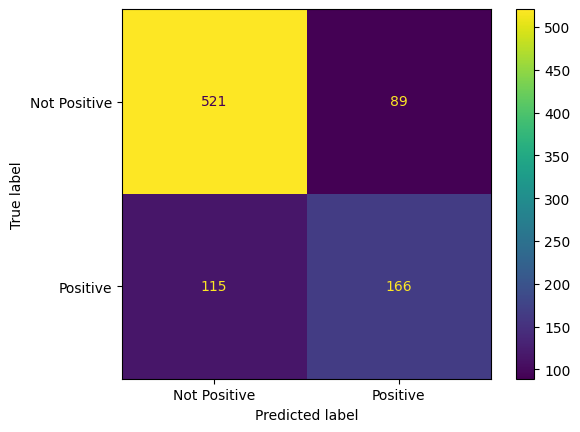

In [127]:
#v1.0
#run this on the standard X_train and y train

pipeline1 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LinearSVC(random_state=24, 
                              ))])
#make a parameter grid
param_grid1 = {
    'tfidf__max_features': [3500],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [0.0],
    'tfidf__max_df': [0.95],
    'tfidf__use_idf': [True],
    'tfidf__stop_words': [stopwords_list],
    'tfidf__sublinear_tf': [True],
    'clf__C': [1,],
    'clf__penalty': ['l2'],
    'clf__loss': ['squared_hinge'],
    'clf__tol': [1e-1]}

    
#run a grid search to find the most accurate version for logistic regression
grid_search1 = GridSearchCV(
    pipeline1,
    param_grid1,
    cv=5,
    scoring='accuracy', 
    n_jobs=1,
    verbose=0)

# Fit the grid search to the training data
grid_search1.fit(X_train_str, y_train)

# Get the best train cross-validation score
best_train_cv_score = grid_search1.best_score_

# Get the best model found by grid search
best_model = grid_search1.best_estimator_

# Predict on the validation set
y_val_pred = best_model.predict(X_val_str)

# Evaluate performance (accuracy) on the validation set
from sklearn.metrics import accuracy_score
val_accuracy = accuracy_score(y_val, y_val_pred)

# Get the best hyperparameters
best_params = grid_search1.best_params_

print(f"Best Train Cross-Validation Score: {best_train_cv_score:.4f}")
print(f"Validation Set Accuracy: {val_accuracy:.4f}")
cm = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Positive', 'Positive']).plot()
plt.show()

# Final model

Final Test Set Accuracy (Tuned Linear SVC Model): 0.7500


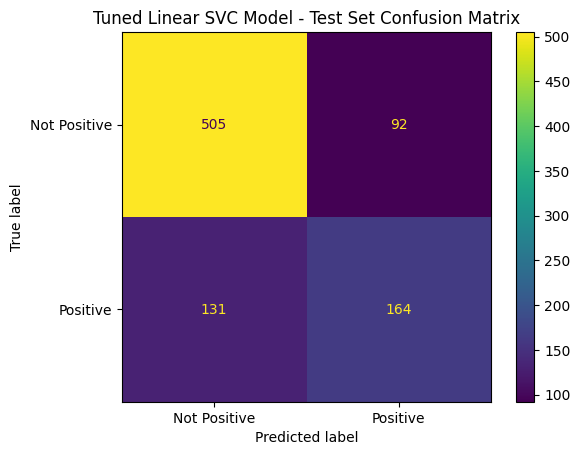

In [129]:
# Recreate the champion pipeline (Logistic Regression with stopwords)
SVC_line = Pipeline([
    ('tfidf', TfidfVectorizer(max_features= 3500,
                              ngram_range= (1, 1),
                              min_df= 0.0,
                              max_df= 0.95, 
                              use_idf= True,
                              stop_words= stopwords_list,
                              sublinear_tf= True)),
    ('clf', LinearSVC(random_state=24,
                      C= 1,
                      penalty= 'l2',
                      loss= 'squared_hinge',
                      tol= 1e-1))])

# Fit on training data
SVC_line.fit(X_train_str, y_train)

# Test set prediction
y_test_pred_SVC = SVC_line.predict(X_test_str)
test_accuracy_SVC = accuracy_score(y_test, y_test_pred_SVC)
cm_test_SVC = confusion_matrix(y_test, y_test_pred_SVC)

print(f"Final Test Set Accuracy (Tuned Linear SVC Model): {test_accuracy_SVC:.4f}")
disp = ConfusionMatrixDisplay(cm_test_SVC, display_labels=['Not Positive', 'Positive'])
disp.plot()
plt.title("Tuned Linear SVC Model - Test Set Confusion Matrix")
plt.show()